## Exercises

### 1. Build a MNIST Classifier that achieves over 97% accuracy on the test set

Step 1 is just assess baseline performance of the suggested KNeighbors classifier

In [5]:
from sklearn.datasets import fetch_openml

In [6]:
mnist = fetch_openml('mnist_784', version=1)

In [46]:
X, y = mnist['data'], mnist['target']

In [75]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
std_scaler = StandardScaler()

In [7]:
X_train_scaled = std_scaler.fit_transform(X_train)

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [9]:
knn_clf = KNeighborsClassifier()
knn_clf

KNeighborsClassifier()

In [10]:
# cross_val_score(knn_clf, X_train_scaled, y_train, cv=3,
#                 scoring='accuracy', verbose=2, n_jobs=-1)

Tune KNN by adjusting number of neighbours

In [11]:
from sklearn.model_selection import GridSearchCV

- Note: do not use large values for K

In [12]:
knn_param_grid = {'n_neighbors': [3, 4, 5],
                  'weights': ['uniform', 'distance']}

In [13]:
# knn_grid_search = GridSearchCV(knn_clf, knn_param_grid,
#                                scoring='accuracy',
#                                return_train_score=True,
#                                cv=3, n_jobs=4, verbose=3)

In [14]:
# knn_grid_search

In [15]:
# knn_grid_search.fit(X_train_scaled, y_train)

In [16]:
# knn_grid_search.best_params_

In [95]:
import pickle

In [96]:
# pickle.dump(knn_grid_search, open( "knn_grid_search.p", "wb" ))

In [97]:
knn_grid_search = pickle.load(open("knn_grid_search.p", "rb" ))

In [98]:
knn_grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [21]:
knn_grid_search.best_score_

0.9437666666666668

In [22]:
from sklearn.metrics import accuracy_score

In [23]:
X_test_scaled = std_scaler.transform(X_test)

In [ ]:
y_pred = knn_grid_search.predict(X_test_scaled)

In [27]:
accuracy_score(y_test, y_pred)

0.9489

Note: KNN seems to perform worse on scaled features than unscaled - perhaps with unstructured data like MNIST it makes sense to just keep the raw features.

### 2. Write a function that can shift a MNIST image in any direction (up, down, left, right). Make four shifted copies (one per direction) and add them to the training set. Retrain your best classifier on them and see performance improve 

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
from scipy.ndimage.interpolation import shift
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [6]:
some_digit = X_train[np.random.randint(len(X_train))]

In [7]:
some_digit.shape

(784,)

In [8]:
some_digit_image = some_digit.reshape(28,28)

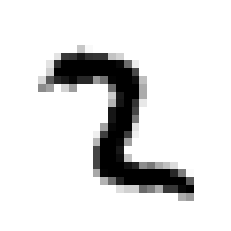

In [9]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [10]:
# test shifting left
some_digit_image_left = shift(some_digit_image, (0,-1), cval=0)

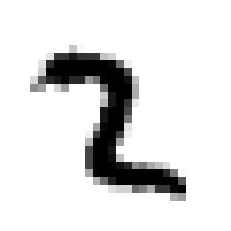

In [11]:
plt.imshow(some_digit_image_left, cmap='binary')
plt.axis('off')
plt.show()

In [12]:
def shift_digit(digit, shift_vals):
    digit_img = digit.reshape(28,28)
    digit_shifted = shift(digit_img, shift_vals, cval=0)
    return digit_shifted.reshape(-1,)

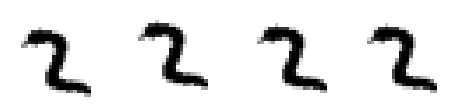

In [13]:
shift_directions = [(1,0), (-1,0), (0,1), (0,-1)]

plt.figure(figsize=(8,4))
for i in range(len(shift_directions)):
    subplot_num = int(f"1{len(shift_directions)}{i+1}")
    plt.subplot(subplot_num)
    shifted_img = shift_digit(some_digit, shift_directions[i]).reshape(28,28)
    plt.imshow(shifted_img, cmap='binary')
    plt.axis('off')


In [14]:
X_train.shape

(60000, 784)

In [15]:
X_train_augmented = [digit for digit in X_train]
y_train_augmented = [label for label in y_train]

In [16]:
for i in range(len(X_train)):
    digit = X_train_augmented[i]
    target_class = y_train_augmented[i]
    for direction in shift_directions:
        shifted_digit = shift_digit(digit, direction)
        X_train_augmented.append(shifted_digit)
        y_train_augmented.append(target_class)
    if i % 10000 == 0:
        print(f'processed {i} digits')

processed 0 digits
processed 10000 digits
processed 20000 digits
processed 30000 digits
processed 40000 digits
processed 50000 digits


In [17]:
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [18]:
X_train_augmented.shape

(300000, 784)

In [19]:
y_train_augmented.shape

(300000,)

In [23]:
# import pickle

In [24]:
# knn_grid_search = pickle.load(open("knn_grid_search.p", "rb" ))
# best_knn_clf = knn_grid_search.best_estimator_

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
best_knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance')
best_knn_clf

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [27]:
best_knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [28]:
y_pred_knn_best = best_knn_clf.predict(X_test)

In [32]:
from sklearn.metrics import accuracy_score

In [33]:
accuracy_score(y_test, y_pred_knn_best)

0.9763

## Build a Spam Classifier

### Download and load the Email Data

In [1]:
import requests
from bs4 import BeautifulSoup
import os
import tarfile

In [2]:
corpus_url = 'https://spamassassin.apache.org/old/publiccorpus/'
r = requests.get(corpus_url)

In [3]:
soup = BeautifulSoup(r.text)

In [4]:
soup.find_all("a")[5].text

'20021010_easy_ham.tar.bz2'

In [5]:
def download_corpus_files(target_dir='email_corpus'):
    corpus_url = 'https://spamassassin.apache.org/old/publiccorpus/'
    r = requests.get(corpus_url)
    soup = BeautifulSoup(r.text)
    
    os.makedirs(target_dir, exist_ok=True)
    
    for link in soup.find_all('a'):
        if link.text.endswith('.tar.bz2'):
            download_url = os.path.join(corpus_url, link.text)
            
            with requests.get(download_url, stream=True) as raw:
                bz2_path = os.path.join(target_dir, link.text)
                
                with open(bz2_path, 'wb') as file:
                    for chunk in raw.iter_content(1024**3):
                        file.write(chunk)
                        
            tar_file = tarfile.open(bz2_path, "r:bz2")
            tar_file.extractall(target_dir)
            tar_file.close()
            os.remove(bz2_path)             

In [6]:
download_corpus_files()

In [7]:
import numpy as np
import shutil

In [8]:
def create_train_test_datasets(corpus='email_corpus', train_size=0.8, seed=42):
    np.random.seed(seed)
    
    train_dir = os.path.join(corpus, "train")
    test_dir = os.path.join(corpus, "test")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    email_dirs = [dir_ for dir_ in os.listdir(corpus) if "am" in dir_]
    
    target_counts = {"spam": 0, "ham": 0}
    
    for dir_ in email_dirs:
        if "spam" in dir_: target = "spam"
        else: target = "ham"
        email_dir = os.path.join(corpus, dir_)
        emails = os.listdir(email_dir)
        emails.remove("cmds")
        emails_shuffled_ix = np.random.randint(0, len(emails),
                                               size=(len(emails)))
        
        train_ix = emails_shuffled_ix[:(int(len(emails)*train_size))]
        test_ix = emails_shuffled_ix[(int(len(emails)*train_size)):]
        
        for ix in train_ix:
            src_file = os.path.join(email_dir, emails[ix])
            dest_file = target + str(target_counts[target])
            shutil.copy(src_file, os.path.join(train_dir, dest_file))
            target_counts[target] += 1
            
        for ix in test_ix:
            src_file = os.path.join(email_dir, emails[ix])
            dest_file = target + str(target_counts[target])
            shutil.copy(src_file, os.path.join(test_dir, dest_file))
            target_counts[target] += 1

In [9]:
create_train_test_datasets()

In [10]:
import re

In [11]:
def load_train_test_datasets(train_dir="email_corpus/train", test_dir="email_corpus/test"):
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    
    for file in os.listdir(train_dir):
        
        with open(os.path.join(train_dir, file), 'rb') as data:
            try:
                target = re.search('(spam|ham).*', file).group(1)
                msg = data.read().decode('utf-8')
                
                # check for duplicate file - if dup don't add
                if msg not in X_train:
                    X_train.append(msg)
                    y_train.append(target)
                    
            except UnicodeDecodeError:
                pass

    for file in os.listdir(test_dir):
        
        with open(os.path.join(test_dir, file), 'rb') as data:
            try:
                target = re.search('(spam|ham).*', file).group(1)
                msg = data.read().decode('utf-8')
                
                # check for duplicate file - if dup don't add
                if msg not in X_test:
                    X_test.append(msg)
                    y_test.append(target)
                    
            except UnicodeDecodeError:
                pass
    
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = load_train_test_datasets()

### Check out some Examples

In [13]:
print(X_train[100])

From webmaster2fg7@address.com  Mon Jul 29 11:21:28 2002
Return-Path: <webmaster2fg7@address.com>
Delivered-To: yyyy@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id F4169440FA
	for <jm@localhost>; Mon, 29 Jul 2002 06:20:54 -0400 (EDT)
Received: from mandark.labs.netnoteinc.com [213.105.180.140]
	by localhost with POP3 (fetchmail-5.9.0)
	for jm@localhost (single-drop); Mon, 29 Jul 2002 11:20:55 +0100 (IST)
Received: from ntserver1.roomscapesinc.com ([66.152.208.34])
	by mandark.labs.netnoteinc.com (8.11.6/8.11.6) with ESMTP id g6RCOEp31273
	for <jm@netnoteinc.com>; Sat, 27 Jul 2002 13:24:15 +0100
Received: from postoffice.address.com (B2V4V9 [66.169.34.86]) by ntserver1.roomscapesinc.com with SMTP (Microsoft Exchange Internet Mail Service Version 5.5.2653.13)
	id PV0X1HWT; Sat, 27 Jul 2002 06:46:01 -0400
Message-ID: <00002fe93c34$000073cd$0000672f@postoffice.address.com>
To: <Undisclosed.Recipients@netnotei

In [14]:
y_train[100]

'spam'

In [15]:
print(X_train[200])

From fork-admin@xent.com  Fri Aug 23 11:08:55 2002
Return-Path: <fork-admin@xent.com>
Delivered-To: yyyy@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D741B47C6F
	for <jm@localhost>; Fri, 23 Aug 2002 06:06:55 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Fri, 23 Aug 2002 11:06:55 +0100 (IST)
Received: from xent.com ([64.161.22.236]) by dogma.slashnull.org
    (8.11.6/8.11.6) with ESMTP id g7N1jTZ04367 for <jm@jmason.org>;
    Fri, 23 Aug 2002 02:45:29 +0100
Received: from lair.xent.com (localhost [127.0.0.1]) by xent.com (Postfix)
    with ESMTP id 6A11E2940F5; Thu, 22 Aug 2002 18:43:08 -0700 (PDT)
Delivered-To: fork@example.com
Received: from smtp03.mrf.mail.rcn.net (smtp03.mrf.mail.rcn.net
    [207.172.4.62]) by xent.com (Postfix) with ESMTP id 2D0CE294099 for
    <fork@xent.com>; Thu, 22 Aug 2002 18:42:41 -0700 (PDT)
X-Info: Th

In [16]:
print(y_train[200])

ham


In [17]:
print(X_train[300])

From rssfeeds@jmason.org  Tue Sep 24 10:47:41 2002
Return-Path: <rssfeeds@spamassassin.taint.org>
Delivered-To: yyyy@localhost.spamassassin.taint.org
Received: from localhost (jalapeno [127.0.0.1])
	by jmason.org (Postfix) with ESMTP id 5932D16F16
	for <jm@localhost>; Tue, 24 Sep 2002 10:47:41 +0100 (IST)
Received: from jalapeno [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Tue, 24 Sep 2002 10:47:41 +0100 (IST)
Received: from dogma.slashnull.org (localhost [127.0.0.1]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g8O80dC26649 for
    <jm@jmason.org>; Tue, 24 Sep 2002 09:00:39 +0100
Message-Id: <200209240800.g8O80dC26649@dogma.slashnull.org>
To: yyyy@spamassassin.taint.org
From: boingboing <rssfeeds@spamassassin.taint.org>
Subject: Warchalking FAQ
Date: Tue, 24 Sep 2002 08:00:39 -0000
Content-Type: text/plain; encoding=utf-8

URL: http://boingboing.net/#85481344
Date: Not supplied

Aaron Swartz has written up a warchalking FAQ that ad

In [18]:
print(y_train[300])

ham


In [45]:
print(X_train[403])

From walteribe@c4.com  Wed Jul  3 12:34:26 2002
Return-Path: <walteribe@c4.com>
Delivered-To: yyyy@localhost.labs.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix on SuSE Linux 8.0 (i386)) with ESMTP id AED2614F8C1
	for <jm@localhost>; Wed,  3 Jul 2002 12:31:07 +0100 (IST)
Received: from dogma.slashnull.org [212.17.35.15]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Wed, 03 Jul 2002 12:31:07 +0100 (IST)
Received: from mail1.chek.com (homer.chek.com [208.197.227.7]) by
    dogma.slashnull.org (8.11.6/8.11.6) with SMTP id g46Dve205900 for
    <jm@jmason.org>; Mon, 6 May 2002 14:57:40 +0100
Received: (qmail 9427 invoked from network); 6 May 2002 13:57:29 -0000
Received: from whiskas.chek.com (208.197.227.138) by mailrelay1.chek.com
    with SMTP; 6 May 2002 13:57:29 -0000
Received: (qmail 24523 invoked by uid 99); 6 May 2002 13:57:28 -0000
Date: 6 May 2002 13:57:28 -0000
Message-Id: <20020506135728.24522.

In [20]:
print(y_train[403])

spam


### Build the data preparation pipeline

In [76]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [60]:
# get html tags corpus
def get_html_tags_list():
    html_tags_url = 'https://www.w3schools.com/tags/'
    r = requests.get(html_tags_url)
    soup = BeautifulSoup(r.text)

    html_tags_list = []
    for td in soup.find_all('td'):
        tag = td.text
        if re.match('^<.*>$', tag) is not None:
            html_tags_list.append(tag)
            close_tag = tag[0] + '/' + tag[1:]
            html_tags_list.append(close_tag) # appending closing version of tag
    
    return html_tags_list

In [61]:
html_tags_list = get_html_tags_list()

In [62]:
def replace_newlines(text, sub=' '):
    return text.replace('\n', sub)

In [65]:
def html_tags_count(text, html_tags_list, binary=False):
    text = replace_newlines(text)
    text = text.lower()
    html_tags_count = 0
    
    for tag in html_tags_list:
        html_tags_count += text.count(tag)
    
    if binary:
        return 1 if html_tags_count > 0 else 0
    
    return html_tags_count

In [133]:
class HtmlTagCounter(BaseEstimator, TransformerMixin):
    def __init__(self, html_tags_list, binary=False):
        self.binary = binary
        self.html_tags_list = html_tags_list
        
    def fit(self, X, y=None):
        return self
    
    def _html_tags_count(self, X):
        text = replace_newlines(X)
        text = text.lower()
        html_tags_count = 0

        for tag in self.html_tags_list:
            html_tags_count += text.count(tag)

        if self.binary:
            return 1 if html_tags_count > 0 else 0

        return html_tags_count
    
    def transform(self, X, y=None):
        vectorized_html_tags_count = np.vectorize(self._html_tags_count)
        return np.c_[vectorized_html_tags_count(X)]

In [134]:
html_tag_counter = HtmlTagCounter(html_tags_list)

In [135]:
X_train_tag_counts = html_tag_counter.transform(X_train)

In [138]:
X_train_tag_counts.reshape(-1,)[:50]

array([  0,   0,   0,   0,   0,   0,   0, 144,   0,   0, 230,   0,   0,
         0,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        45,   0,   0,   0,   0,  88,   0,   0,   0,   0,   0,   0, 114,
        77,   0,   0,   0,   0, 133,   0,   0,   0,  91,   0])

In [139]:
text_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])

html_tag_pipeline = Pipeline([
    ('html_tag_counter', HtmlTagCounter(html_tags_list))
])

full_pipeline = FeatureUnion([
    ('text', text_pipeline),
    ('html_tag', html_tag_pipeline)
])

In [140]:
X_train_prepared = full_pipeline.fit_transform(X_train)

In [145]:
full_pipeline.get_feature_names()

AttributeError: Transformer text (type Pipeline) does not provide get_feature_names.

In [141]:
X_train_prepared

<4612x109503 sparse matrix of type '<class 'numpy.float64'>'
	with 1241016 stored elements in Compressed Sparse Row format>